<a href="https://colab.research.google.com/github/Sicily-F/cagedbirdID/blob/main/8_Training_convolutional_networks_training_the_models_for_species_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8. Training convolutional networks: training the models for species identification

## The structure of neural networks
An artificial neuron in a neural network has several inputs, each with an associated weight. For each artificial neuron, the inputs are multiplied by the weights, summed, and then evaluated by a non-linear function, called the activation function (e.g., Sigmoid, Tanh, ReLu, or Sine) (Tabak et al., 2018). A softmax function is used at the final layer to ensure that the sum of the outputs equals one, i.e., the maximum probability outputted per class is 1 (Tabak et al., 2018).


Convolutional layers can be viewed as applications of a filter to an input that results in activation. Repeatedly applying the same filter to an input results in a map of activations called a feature map, which indicates a detected feature’s location in an input, such as an image. In images, these features are maps of pixels. Pooling layers build robustness to minor distortions in images (Niemi & Tanttu, 2018). GAP layers transform an M x M x N feature map to a 1 x N feature map where M x M is the size of the image, and N is the number of filters (Kumar et al., 2021). They reduce the feature map's size, thus minimising the computation time (Kumar et al., 2021; Z. Li et al., 2019). Additionally, GAP layers do not require parameter optimisation, which minimises the risk of overfitting.  

The standard CNN, the dominant architecture used for image classification, is built with fully connected layers and several blocks consisting of convolutions, an activation function layer, and pooling layers (Buda et al., 2018). Training and evaluating the performance of CNN’s requires significant computational power, which is aided with modern graphical processing units (GPU’s) (Buda et al., 2018). Generally, the input sources for CNN architectures are an image with RGB (red, blue, green) pixel channels and fixed size (for example, 224 x 224 pixels). The output is the predicted species class, as for many other camera trap image-based species classification models (Schneider et al., 2020). 


## References
Buda, M., Maki, A., & Mazurowski, M. A. (2018). A systematic study of the class imbalance problem in convolutional neural networks. Neural Networks: The Official Journal of the International Neural Network Society, 106, 249–259. https://doi.org/10.1016/j.neunet.2018.07.011  

Kumar, R. L., Kakarla, J., Isunuri, B. V., & Singh, M. (2021). Multi-class brain tumor classification using residual network and global average pooling. Multimedia Tools and Applications, 80(9), 13429–13438. https://doi.org/10.1007/s11042-020-10335-4

Li, Z., Wang, S.-H., Fan, R.-R., Cao, G., Zhang, Y.-D., & Guo, T. (2019). Teeth category classification via seven-layer deep convolutional neural network with max pooling and global average pooling. International Journal of Imaging Systems and Technology, 29(4), 577–583. https://doi.org/10.1002/ima.22337

Niemi, J., & Tanttu, J. T. (2018). Deep Learning Case Study for Automatic Bird Identification. Applied Sciences, 8(11), 2089. https://doi.org/10.3390/app8112089

Schneider, S., Greenberg, S., Taylor, G. W., & Kremer, S. C. (2020). Three critical factors affecting automated image species recognition performance for camera traps. Ecology and Evolution, 10(7), 3503–3517. https://doi.org/10.1002/ece3.6147

Tabak, M. A., Norouzzadeh, M. S., Wolfson, D. W., Sweeney, S. J., Vercauteren, K. C., Snow, N. P., Halseth, J. M., Di Salvo, P. A., Lewis, J. S., White, M. D., Teton, B., Beasley, J. C., Schlichting, P. E., Boughton, R. K., Wight, B., Newkirk, E. S., Ivan, J. S., Odell, E. A., Brook, R. K., … Miller, R. S. (2018). Machine learning to classify animal species in camera trap images: Applications in ecology. Methods in Ecology and Evolution. https://doi.org/10.1111/2041-210X.13120






Following a literature review, we selected a range of machine learning architectures which were suitable for a bird classification problem. These were initialised with ImageNet weights, minus the top layer, known as a ‘headless’ model. For all CNN’s, the headless model was stacked with a global average pooling layer (GAP), a fully connected Dense layer (size 1024, with ReLu activation function). The last layer of each model was replaced with a Dense layer of size 37, following the number of classes (bird species). The activation of the classifier layer was controlled by the softmax function. This function allocates decimal probabilities to each class, which add up to one. 

There are a lot of terms, some of which we will describe here (the brackets are how the term is defined in the code below) - please also refer to file 3. the glossary of machine learning terms:

* *Optimiser* (opt): minimises error
* *Learning rate* (lr): determine how a network is trained 
* *Prediction layer* (predictions): The last layer is prediction layer, which specifies 37classes (bird species). The activation of the classifier layer was controlled by the softmax function. This function allocates decimal probabilities to each class, which add up to one. 

## Data augmentation and random erasing
When we wanted to investigate the effect of data augmentation more specifically on model performance, we carried out real-time, online augmentation in TensorFlow, which is less computationally expensive. In the training dataset, we rotated images, flipped them, and shifted their width and height. Only augmenting training data allows the augmentation effect to be deduced from the validation and training accuracies.

We tested the ability of models to deal with occlusion using random erasing, which is a form of data augmentation. In random erasing, each image within a batch randomly undergoes two possible operations; either it remains unchanged or an area of the image is masked with randomised pixels. This makes the model more robust to noise and occlusion in images during training.

An example of the effect of random erasing can be seen here:

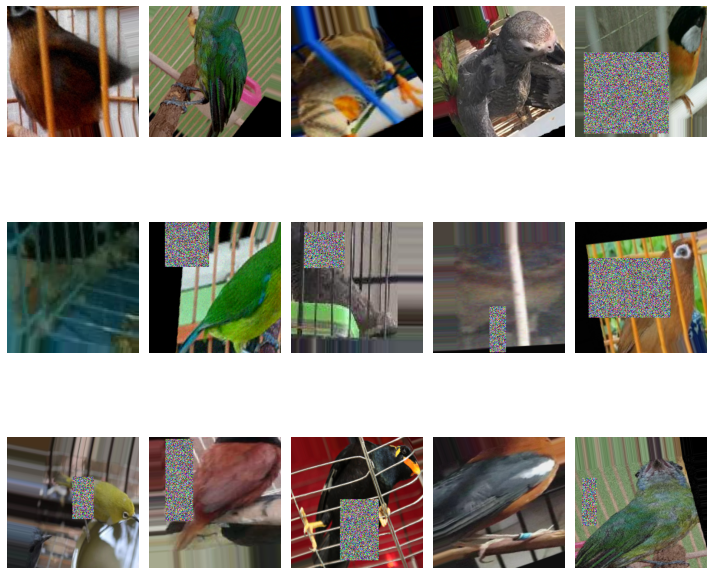

There are different ways to use random seeds in TensorFlow, we used the last option - these are just here to show you the other options.
```
import tensorflow as tf

tf.set_random_seed(96)
np.random.seed(1337) # To reproduce your results: https://github.com/keras-team/keras/issues/2743

## GLOBAL SEED ##                                                   
tf.random.set_seed(3)
RANDOM_SEED = 1
```




In [ ]:
import numpy as np	
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import PIL
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img #shift away from relying on keras, no keras is embedded within tensorflow
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import os

TRAIN_DIR = 'all_species_cropped_balanced/train'
VAL_DIR = 'all_species_cropped_balanced/val'
TEST_DIR= 'all_species_cropped_balanced/test'


# Code modified from here: https://github.com/yu4u/cutout-random-erasing
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=True): # was False before, as true still doesn't help me do the pixel level implementation 
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

BATCH_SIZE = 16  # The batch size control the number of images used in every epoch
# These are the pixel dimensions for the images, 224 x 224 pixels wide
IMG_HEIGHT = 224
IMG_WIDTH = 224
RANDOM_SEED = 1

# This loads the images into Tensorflow, they are rescaled using the rescale function, which ensures all photos are in the same pixel format
datagen = ImageDataGenerator(
    rescale=1/255,
    preprocessing_function=get_random_eraser(v_l=0, v_h=255, pixel_level=True),
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
    
train_gen = datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

testgen = ImageDataGenerator(
    rescale=1/255) 
    
val_gen = testgen.flow_from_directory(
    VAL_DIR, 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)
    
test_gen = testgen.flow_from_directory(
    TEST_DIR, 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size= BATCH_SIZE,
    shuffle=False,
    seed=RANDOM_SEED
)

# create the base pre-trained model
base_model = DenseNet201(weights='imagenet', include_top=False)
x = base_model.output
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(37, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#remember categorical not binary used as we are working with multiple classes

#remember that model.fit_generator may now be deprecated, do might have to
#switch to model.fit but you can still call the generator functions: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
#You could also call it directly by using tf.keras.callbacks but that's kinda long, because we imported tensorflow as tf, don't forget

filepath = "Densenet201augre16.h5" # has now been changed to just "DenseNet.h5", which saves the output into my general file, this put it as a file the folder ~
#newfilepath

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# stop training if there is no improvement in model for 3 consecutives epochs.
early_stopping_monitor = EarlyStopping(patience=3)#was 3 before and with val_acc

callbacks_list = [checkpoint, early_stopping_monitor]

#tf.keras.metrics.Precision
#tf.keras.metrics.Recall

#from tensorflow.keras.optimizers import Adam
#opt = Adam(lr=0.00001)#should ideally be the same as the min_lr in the ReduceLRonPlateau

from tensorflow.keras.optimizers import SGD

opt = SGD(lr=0.01, momentum=0.0,)#should ideally be the same as the min_lr in the ReduceLRonPlateau

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]) 
#this is a compile API

#how to get F1 scores for multiclass classification

EPOCHS = 100
history = model.fit(
    train_gen,#will be faster if you don't have the augmentation,
    steps_per_epoch = train_gen.samples // BATCH_SIZE,
    validation_data = val_gen, 
    validation_steps = val_gen.samples // BATCH_SIZE,
    epochs = EPOCHS,
    shuffle = True,
    callbacks=callbacks_list)

## How to save your model
The code below saves the model in our root directory, in a new folder, which is named for the first time here, the 'densenet201' folder. This creates a SavedModel folder, which you can use to build applications.


```
model.save('densenet201')
```





## How to check for overfitting
One risk of training with small datasets is the potential for overfitting to occur when there is a decrease in accuracy between the training and validation sets, or where there is an overly complex model for a limited dataset. Overfitting can result in the model only recognizing some classes when they appear in combination with specific backgrounds seen during training, or the model performs well on the training data but not the validation data.

In [ ]:
# Influenced by this other Github repository: https://github.com/AndreCFerreira/Bird_individualID/blob/master/Train_CNN/TRAIN_CNN.ipynb

# Size of the plots
fig=plt.figure(figsize=(15,5))
columns = 2
rows = 1

#plot loss
#the accuracy and loss are stored in the "model_history"
fig.add_subplot(rows, columns, 1)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# plot accuracy
fig.add_subplot(rows, columns, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('densere.pdf')#careful not to overwrite old files

In [ ]:
# This gives the batch test accuracy. This calculates the proportions of correct predictions in a randomised batch from the test dataset (in our case for a randomised batch of 16 images)
test_batch_x, test_batch_y = test_gen.next()
pred_batch = model.predict(test_batch_x)

test_labels = np.argmax(test_batch_y, axis=1)
test_pred = np.argmax(pred_batch, axis=1)

test_acc = sum(test_labels == test_pred) / len(test_labels)
print('Accuracy: %.3f' % test_acc)


## How to print and display a confusion matrix for your classes

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
Y_pred = model.predict(test_gen, test_gen.samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
# code found here: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac?noredirect=1&lq=1

print(confusion_matrix(test_gen.classes, y_pred))

print('Classification Report')

target_names = ['asian_pied', 'bali_myna', 'bluethroat', 'bm_leafbird', 'bn_oriole', 'bw_myna', 'c_laughingthrush', 'c_whiteeye', 'cc_thrush', 'chestnut_munia', 
                'common_myna', 'fischers_lovebird', 'gg_leafbird', 'grey_parrot', 'grosbeak', 'hill_myna', 'hwamei',
                'javan_sparrow', 'jg_magpie', 'leiothrix', 'lt_shrike', 'oh_thrush', 'om_robin', 'r_laughingthrush', 
                'red_billedstarling', 'red_whiskered', 'rubythroat', 'sb_munia', 'sh_bulbul', 'silver_eared',
                'su_laughingthrush', 'swinhoes', 'wr_munia', 'ws_shama', 'z_dove', 'z_finch']

print(classification_report(test_gen.classes, y_pred, target_names=target_names))

cm = confusion_matrix(test_gen.classes, y_pred)

import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Oranges):#was Blues before, refer here for help: https://stackoverflow.com/questions/57043260/how-change-the-color-of-boxes-in-confusion-matrix-using-sklearn

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(20,20)) #was (10,10) before



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=90)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# how to plot it: https://stackoverflow.com/questions/65317685/how-to-create-image-of-confusion-matrix-in-python
plt.savefig("cfmdensenetnone.png", dpi=300) # dpi can control the resolution

# The accuracy printed here will be the accuracy over the entire test set, not just a random batch
